# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [31]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [ ]:
def make_df(start_date, end_date, df_init):
    actions_aggs = {}
    actions_id_to_suf = {
        1: "click",
        2: "favorite", 
        3: "order",
        5: "to_cart",
    }

    # Сначала соберем все агрегированные данные
    all_aggs = []
    numeric_features = []

    for id_, suf in actions_id_to_suf.items():
        aggs = (
            actions_history
            .filter(pl.col('timestamp').dt.date() <= end_date)
            .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30 * 5))
            .filter(pl.col('action_type_id') == id_)
            .join(
                product_information.select('product_id', 'discount_price'),
                on='product_id',
            )
            .group_by('user_id')
            .agg(
                pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
                pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
                pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
                pl.max('timestamp').alias(f'last_{suf}_time'),
                pl.min('timestamp').alias(f'first_{suf}_time'),
            )
            .with_columns([
                (pl.lit(start_date) - pl.col(f'last_{suf}_time'))
                .dt.total_days()
                .cast(pl.Int32)
                .alias(f'days_since_last_{suf}'),
                
                (pl.lit(start_date) - pl.col(f'first_{suf}_time'))
                .dt.total_days()
                .cast(pl.Int32)
                .alias(f'days_since_first_{suf}'),
            ])
        )
        
        # Сохраняем имена числовых фичей для последующего создания полиномов
        numeric_features.extend([
            f'num_products_{suf}',
            f'sum_discount_price_{suf}', 
            f'max_discount_price_{suf}',
            f'days_since_last_{suf}',
            f'days_since_first_{suf}',
        ])
        
        actions_aggs[id_] = aggs
        all_aggs.append(aggs)

    # Объединяем все агрегации по user_id с указанием суффиксов
    combined = all_aggs[0]
    for i, agg in enumerate(all_aggs[1:], 1):
        combined = combined.join(
            agg, 
            on='user_id', 
            how='left',
            suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
        )



    # search_aggs
    id_ = 4
    suf = 'search'

    # Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
    cluster_counts = (
        search_history
        .filter(pl.col('action_type_id') == id_)
        .filter(pl.col('timestamp').dt.date() <= end_date)
        .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30 * 5))
        .group_by('user_id')
        .agg(
            pl.col('cluster').value_counts().alias('cluster_counts')
        )
        .explode('cluster_counts')
        .with_columns(
            pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
            pl.col('cluster_counts').struct.field('count').alias('cluster_count')
        )
        .group_by('user_id')
        .agg(
            pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
            pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
        )
    )

    actions_aggs[id_] = (
        search_history
        .filter(pl.col('action_type_id') == id_)
        .filter(pl.col('timestamp').dt.date() <= end_date)
        .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30 * 5))
        .group_by('user_id')
        .agg(
            # Общее количество поисков за 5 месяцев
            pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
            pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
            
            # Количество поисков за последний месяц (30 дней)
            pl.col('search_query')
                .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30))
                .count()
                .cast(pl.Int32)
                .alias(f'num_{suf}_last_month'),
            
            # Количество поисков за последнюю неделю (7 дней)
            pl.col('search_query')
                .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=7))
                .count()
                .cast(pl.Int32)
                .alias(f'num_{suf}_last_week'),

            (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

            pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
            pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
            
            # Динамика кластеров
            pl.col('cluster')
                .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30))
                .mode().first()
                .alias(f'recent_{suf}_cluster'),

            (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
            
            # Энтропия кластеров (мера разнообразия)
            (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
                * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
                .sum()).alias(f'{suf}_cluster_entropy'),
            
            # Переключения между кластерами
            pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
            
            # Стабильность кластеров (процент повторяющихся)
            ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
                .alias(f'{suf}_cluster_stability'),
            
            # Время в основном кластере
            (pl.col('timestamp')
                .filter(pl.col('cluster') == pl.col('cluster').mode().first())
                .count() / pl.col('timestamp').count())
                .alias(f'main_{suf}_cluster_time_ratio'),

            pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
                .diff()
                .dt.total_days()
                .mean()
                .alias(f'{suf}_mean_cluster_switch_days'),

            pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
            
            (pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
                pl.col('search_query').str.len_chars()
                    .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                    .alias(f'{suf}_main_cluster_query_len_diff'),

            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .join(cluster_counts, on='user_id', how='left')
        .with_columns([
            (pl.lit(start_date) - pl.col(f'last_{suf}_time'))
                .dt.total_days()
                .cast(pl.Int32)
                .alias(f'days_since_last_{suf}'),

            (pl.lit(start_date) - pl.col(f'first_{suf}_time'))
                .dt.total_days()
                .cast(pl.Int32)
                .alias(f'days_since_first_{suf}'),
        ])
        .select(
            'user_id',
            f'num_{suf}',
            f'unique_{suf}_queries',
            f'num_{suf}_last_month',
            f'num_{suf}_last_week',
            f'{suf}_daily_rate',
            f'num_{suf}_clusters',
            f'main_{suf}_cluster',
            pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
            pl.col('top3_counts').alias(f'top3_{suf}_counts'),
            f'recent_{suf}_cluster',
            f'{suf}_cluster_concentration',
            f'{suf}_cluster_entropy',
            f'{suf}_cluster_switches',
            f'{suf}_cluster_stability',
            f'main_{suf}_cluster_time_ratio',
            f'{suf}_mean_cluster_switch_days',
            f'{suf}_mean_query_len',
            f'{suf}_main_cluster_query_len_diff',
            f'days_since_last_{suf}',
            f'days_since_first_{suf}',
            f'last_{suf}_time',
            f'first_{suf}_time',
        )
    )

    product_cluster_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= end_date)
        .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30 * 5))
        .join(
            product_information.select('product_id', 'cluster'),
            on='product_id'
        )
        .group_by('user_id')
        .agg(
            # Общие агрегаты по кластерам продуктов
            pl.col('cluster').n_unique().alias('num_product_clusters'),
            pl.col('cluster').mode().first().alias('main_product_cluster'),
            
            # Аналогичные агрегаты как для search
            (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
            
            # Энтропия кластеров продуктов
            (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
                * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
                .sum()).alias('product_cluster_entropy'),
            
            # Стабильность кластеров продуктов
            ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
                .alias('product_cluster_stability'),
            
            # Время в основном кластере продуктов
            (pl.col('timestamp')
                .filter(pl.col('cluster') == pl.col('cluster').mode().first())
                .count() / pl.col('timestamp').count()
            ).alias('main_product_cluster_time_ratio'),
                
            # Top 3 кластеров продуктов
            pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
            pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
        )
        .with_columns(
            pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
            pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
        )
        .drop(['top_product_clusters', 'top_product_counts'])
    )

    df_main = df_init
    for _, actions_aggs_df in actions_aggs.items():
        df_main = (
            df_main
            .join(actions_aggs_df, on='user_id', how='left')
        )

    df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
        
    df_pd = df_main.to_pandas()

    return df_pd


In [ ]:
df_pd = make_df(val_start_date, train_end_date, val_target)

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_34800\2027329634.py:120: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [34]:
knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability']

df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


In [35]:
#from local_utils import *

#df_pd = add_polynomial_features_pd(df_pd, cols)

In [36]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

tr, val = get_split(df_pd, val_size=0.25)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

In [37]:
'''import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import time

# Функция для оптимизации
def objective(trial):
    # Параметры для оптимизации
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',  # или 'goss'/'dart', но не меняем в оптимизации
        'learning_rate': trial.suggest_float('eta', 0.001, 0.1, log=True),
        'num_leaves': trial.suggest_int('max_leaves', 7, 255),
        'reg_lambda': trial.suggest_float('linear_lambda', 0.0, 10.0),
        'verbose': -1,
        'importance_type': 'split',
        'early_stopping_rounds': 50  # Добавлено значение по умолчанию для early_stopping_rounds
    }
    
    # Разделение на train и validation (используем ваше исходное разделение)
    X_train = tr[cols]
    y_train = tr['target']
    X_val = val[cols]
    y_val = val['target']
    
    # Обучение модели
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(params['early_stopping_rounds'])]
    )
    
    # Прогноз на валидации
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    return auc

# Оптимизация с ограничением времени
study = optuna.create_study(direction='maximize')
start_time = time.time()
timeout = 600  # 10 минут в секундах

while time.time() - start_time < timeout:
    study.optimize(objective, n_trials=1)
    remaining_time = timeout - (time.time() - start_time)
    if remaining_time <= 0:
        break
    print(f"Remaining optimization time: {remaining_time:.1f} seconds")

# Лучшие параметры
print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Обучение финальной модели с лучшими параметрами
best_params = trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'importance_type': 'split',
    'early_stopping_rounds': 50  # Добавлено значение по умолчанию
})

# Используем полное обучение (train + val) для финальной модели
full_train = pd.concat([tr, val])
X_train = full_train[cols]
y_train = full_train['target']

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Прогноз на тестовых данных
df_pd['predict'] = final_model.predict_proba(df_pd[cols])[:, 1]
df_pd[['user_id', 'predict']].to_csv('optimized_prod_clust.csv', index=False)

# Вывод важности фичей
plot_lgbm_importance(final_model, cols, importance_type='split', top_k=30, sklearn_style=True)'''

'import optuna\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import roc_auc_score\nimport time\n\n# Функция для оптимизации\ndef objective(trial):\n    # Параметры для оптимизации\n    params = {\n        \'objective\': \'binary\',\n        \'metric\': \'auc\',\n        \'boosting_type\': \'gbdt\',  # или \'goss\'/\'dart\', но не меняем в оптимизации\n        \'learning_rate\': trial.suggest_float(\'eta\', 0.001, 0.1, log=True),\n        \'num_leaves\': trial.suggest_int(\'max_leaves\', 7, 255),\n        \'reg_lambda\': trial.suggest_float(\'linear_lambda\', 0.0, 10.0),\n        \'verbose\': -1,\n        \'importance_type\': \'split\',\n        \'early_stopping_rounds\': 50  # Добавлено значение по умолчанию для early_stopping_rounds\n    }\n    \n    # Разделение на train и validation (используем ваше исходное разделение)\n    X_train = tr[cols]\n    y_train = tr[\'target\']\n    X_val = val[cols]\n    y_val = val[\'target\']\n    \n    # Обучение модели\

In [38]:
params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 485948, number of negative: 920268
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18846
[LightGBM] [Info] Number of data points in the train set: 1406216, number of used features: 96
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345571 -> initscore=-0.638563
[LightGBM] [Info] Start training from score -0.638563
Training until validation scores don't improve for 60 rounds
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is

feature_importance: [  86   76  558   69   34   84  312   42   73  620  380  224  237    8
    0  114   11  666   63   30   95 1282   21   36    0   65  445   17
    5  321    4  423  103  589   90  299   16    4  117   25  389  488
  287   40   15  304   61  355   29   24  525   83  732   32   90    2
  437   19  304  185  441   50  780  465  256   32 1249   61   25 1538
  225    0  519  366   21  117  187    7   49   54    0    0    0  728
   42  194   71   17   23   38    4  904    0   62  121  219] 



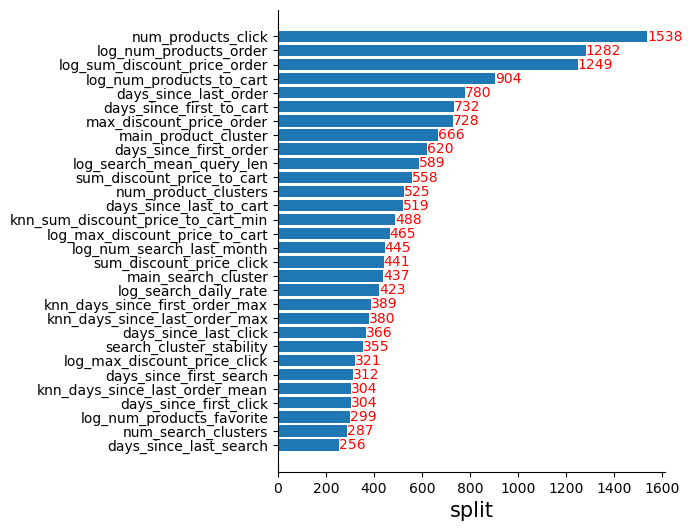

In [39]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [ ]:
val_df_pd = make_df(test_start_date, val_end_date, test_users_submission)
val_df_pd = apply_log_transform(val_df_pd, columns_to_log, drop_original=True)
val_df_pd = add_knn_features_faiss(val_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

#val_df_pd = add_polynomial_features_pd(val_df_pd, cols)

C:\Users\Admin\AppData\Local\Temp\ipykernel_34800\2027329634.py:120: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


In [41]:
val_df_pd['predict'] = model.predict_proba(val_df_pd[cols])[:, 1]
val_df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.165669
1,9852,0.834436
2,10206,0.220483
3,11317,0.231597
4,13289,0.618407
...,...,...
2068419,11157283,0.207598
2068420,11160395,0.149148
2068421,11165052,0.602190
2068422,11168218,0.509505


In [43]:
val_df_pd[['user_id', 'predict']].to_csv('prod_cv_0.csv', index=False)